# Mediterranean Fish Classifier

In this notebook I create 14 image datasets of the Mediterranean fish I see (often) underwater in the French Riviera using Christian Werner's [fastclass](https://github.com/cwerner/fastclass). 

I then build an image recognition model using [fastai](https://www.fast.ai/). I achieve a 8% error rate, with most errors between sardines and anchovies (merging these two would probably get me an error rate $<5\%$)

This notebook is adapted from a notebook by Francisco Ingham and Jeremy Howard, itself inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/). 

Improvements / next steps:
- Deploy a web app (check https://www.pythonanywhere.com/)
- Category changes/adds: 
  - Merge sardines & anchovies together and see what error rate we get
  - Add anemone, urchin, baracuda, cenilabre, serran, gobie, blennie, mulet gris ou bogue, seiche, the flying fish, the tiny neon fish ~5m deep. 
- (Create a questionnaire-based version for app in case of no images) 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import pandas as pd
import numpy as np

## Create Datasets with fastclass

### Search

With [fastclass](https://github.com/cwerner/fastclass), you first need to create a csv file with two columns: searchterm,exclude. Search terms are separated by whitespaces. 

Mine, named `med_fish.csv` looks something like below. I ended up using the scientific names as it would turn up less fishing / cooking results and thus entail less cleaning afterwards, and then renamed the folder with common name. I didn't see big improvements using exclude terms. 

```
searchterm,exclude
"pelagia noctiluca"
"gobiidae mediterranean" "gobie mediterranean"
"coris julis"
"sarpa salpa"
"octopus vulgaris"
"sparus aurata"
"chromis chromis mediterranean"
"apogon imberbis"
"dasyatis pastinaca"
engraulidae
"sardina pilchardus"
"thalassoma pavo"
"muraena helena"
"mola mola mediterranean"
``` 

### Download 

Next step is to use the `Terminal` to run the download command (after you've installed fastclass, see GH). The line below creates a `med_fish` folder and within it as many folders as there are rows in my csv, with the respective images in each of them (coming from searches on Bing & Google). The command also runs a deduplicating algorithm, and resizes the images.

```
fcd -c ALL -k -o med_fish med_fish.csv
```

### Clean
Then you can clean your images, one folder (class) at a time. Entering the command below in the Terminal opens a window in which you can quickly validate/delete images (here of the common stingray). It took me on average a few minutes for a 600 image folder. 

*To keep things fast, I used only `d` for delete, `9` for keep*

```
fcc med_fish/dasyatis_pastinaca
```

## Upload/Download images

Upload your folder (dest: content in this nb). For colab, you'll probably need to compress it into a zipped file and then unzip it. 

In [4]:
!unzip -q 'med_fish.zip' -d ../ #-q for quiet, -qq for quieter

### If a direct upload doesn't work

Before I made the zipped file work (thanks to the [StackExchange page on that](https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab)), I created a (slow) workaround, by going back to a URL csv and then using the fastai function to download the images, for each class. I'll leave it here in case there's problem with the zipped file (`cmd` + `/` to (un)comment selected lines)

In [ ]:
# Get the classes formatted correctly for fastclass
#classes = list(pd.read_csv(path/'med_fish.csv')['searchterm'])
#classes = [c.replace("\"", "").replace(" ", "_") for c in classes]
#classes

In [ ]:
# import re 

# for c in classes:
#   # Get log & clean files
#   name = c + '.log'
#   log = pd.read_csv(path/name, error_bad_lines=False)
#   name = c + '_report_clean.csv'
#   clean = pd.read_csv(path/name, header=None).iloc[1:,0]

#   # Transform imagename in clean to match log format 
#   patrn = '(?!\w+/){2}(\d+.\w+)' #regex exp to match `img_num.jpg`
#   clean = [re.search(patrn, r).group(1) for r in clean]
#   clean = pd.Series(clean, name="image")

#   # merge log and clean to keep only clean URLs
#   log.merge(clean)
#   url = log['source']

#   # save to a csv
#   file = 'urls_' + c + '.csv'
#   url.to_csv(path/file, header=None, index=None)

#   # download images usin fastai fn
#   dest = path/c
#   download_images(path/file, dest) #, max_pics=50)
#   verify_images(path/c, delete=True, max_size=500)

## View data

In [5]:
path = Path('/med_fish')

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If you're coming back after having cleaned your data, run this cell instead
#np.random.seed(42)
#data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [7]:
data.classes

['anchois',
 'apogon',
 'castagnole',
 'daurade',
 'girelle',
 'girelle_paon',
 'meduse',
 'mola_mola',
 'murene',
 'poulpe',
 'raie',
 'sar',
 'sardine',
 'saupe']

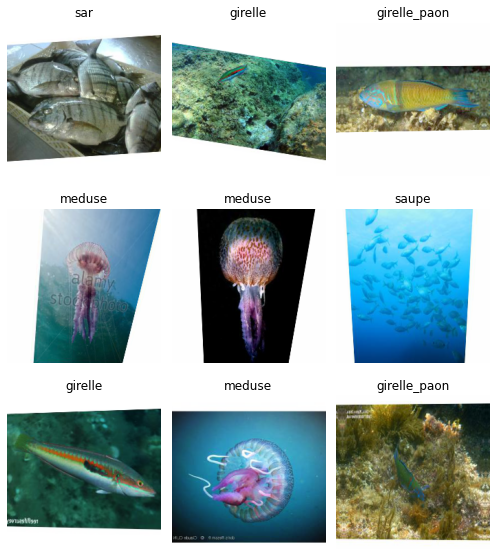

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['anchois',
  'apogon',
  'castagnole',
  'daurade',
  'girelle',
  'girelle_paon',
  'meduse',
  'mola_mola',
  'murene',
  'poulpe',
  'raie',
  'sar',
  'sardine',
  'saupe'],
 14,
 3396,
 849)

## Train model

Side note: I uploaded the uncleaned images on my first run of this notebook, and was having troubling getting an error rate below .17. Uploading the clean folder got me an error rate of .17 on the first epoch, .12 after 4 epochs.

In [10]:
# initiate 34-layer ResNet model
learn = cnn_learner(data, models.resnet34, metrics=error_rate) 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [11]:
# fit 6 epochs with pretrained weights for most layers except the final ones
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.943011,0.624289,0.177856,00:39
1,1.062811,0.465688,0.136631,00:38
2,0.684121,0.352422,0.117786,00:38
3,0.489608,0.301648,0.101296,00:38
4,0.376790,0.275144,0.089517,00:38
5,0.300343,0.273153,0.089517,00:39


After 6 epochs, I get a train loss about the same or lower than the valid loss, and the error rate starts going back up at the very end, so that's the right number of passes.

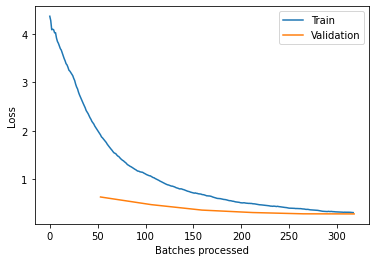

In [13]:
learn.recorder.plot_losses()

In [12]:
# Save V1 model
learn.save('stage-1') 

In [14]:
# 'Unfreeze' all the layers to train them all
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


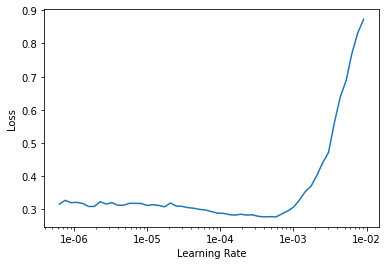

In [15]:
# Record the error rate with different learning rates 
# to use with recorder.plot() to find the best lr 
learn.lr_find() #use this one by default
#learn.lr_find(start_lr=1e-05, end_lr=1e-01)
learn.recorder.plot() 

Above, we're looking for the range with the strongest downward slope, and we can take a x-axis number ~ middle. Takes time getting good at this, if hesitant between 2, try both! Note that we don't see a very strong downward slope, but definetively a strong upward one starting ~1e-3. 

Jeremy's rule of thumbs: start with 3e-3 for stage 1, then 10x lower for stage 2, work in most cases.

In [16]:
# Fit epochs with a given lr slice
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.262035,0.264593,0.093051,00:43
1,0.233842,0.235675,0.075383,00:43
2,0.193830,0.226058,0.078916,00:43
3,0.153179,0.206896,0.068316,00:43
4,0.116545,0.206346,0.074205,00:42
5,0.093454,0.205923,0.075383,00:43


In [17]:
# Save above findings for later use
learn.save('stage-2') 

## Interpretation

In [18]:
# Load above findings
learn.load('stage-2');

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

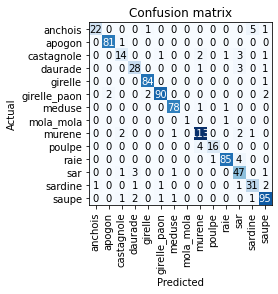

In [20]:
interp.plot_confusion_matrix()

Our biggest mistake comes from the distinction between anchovies and sardines - to be expected as most pictures as schools of them for afar, and I personally can't make the difference.  

## Cleaning Up

The clean up was done ahead of time using fastclass. I'm still leaving that here just in case. 


~~ 

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong. They will be shown in order of 'error' - no need to go through them all, once they start seeming normal just stop. 

In [ ]:
#from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demonstrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
# db = (ImageList.from_folder(path)
#                    .split_none()
#                    .label_from_folder()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [ ]:
# # If you already cleaned your data using indexes from `from_toplosses`,
# # run this cell instead of the one before to proceed with removing duplicates.
# # Otherwise all the results of the previous step would be overwritten by
# # the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                     .split_none()
#                     .label_from_df()
#                     .transform(get_transforms(), size=224)
#                     .databunch()
#       )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
# learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
# learn_cln.load('stage-2');

In [ ]:
# ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [ ]:
# # Don't run this in google colab or any other instances running jupyter lab.
# # If you do run this on Jupyter Lab, you need to restart your runtime and
# # runtime state including all local variables will be lost.
# ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
# ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
# ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

In [ ]:
# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                     .split_none()
#                     .label_from_df()
#                     .transform(get_transforms(), size=224)
#                     .databunch()
#       )

In [ ]:
# learn = cnn_learner(db, models.resnet34, metrics=error_rate)
# learn = learn.load('stage-2')

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [21]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used). When using colab, remember to download it.. 

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [22]:
defaults.device = torch.device('cpu')

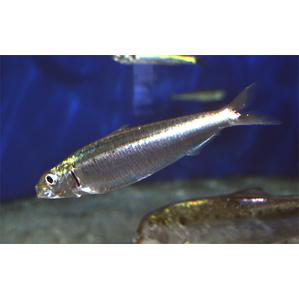

In [24]:
img = open_image(path/'sardine'/'000002.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [25]:
learn = load_learner(path)

In [26]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'sardine'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

Valid loss gets high, well above 1. You need to recreate the NN from the start, can't undo it. 

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,27.246103,32.925461,0.766784,00:41


### Learning rate (LR) too low

Takes too much time to lower error rate. Training loss higher than valid loss, something we never want. 

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,4.129673,3.197954,0.903416,00:41
1,4.030234,2.947195,0.869258,00:41
2,3.811918,2.729595,0.831567,00:41
3,3.685222,2.625941,0.810365,00:42
4,3.623276,2.614368,0.796231,00:41


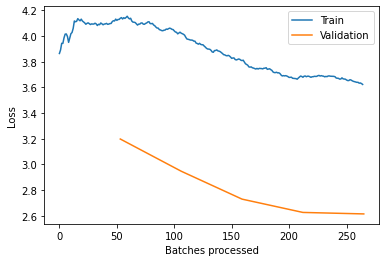

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

Training loss higher than validation loss. 

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,3.138810,2.211083,0.710247,00:44


### Too many epochs

Overfit

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,3.247046,2.966684,0.896073,00:42
1,3.044431,2.834085,0.877225,00:37
2,2.811224,2.511670,0.785340,00:37
3,2.446504,2.032905,0.628272,00:37
4,2.039437,1.562698,0.457068,00:37
5,1.634992,1.259363,0.367016,00:37
6,1.284831,1.092582,0.318586,00:37
7,0.996726,1.001027,0.295026,00:37
8,0.768705,0.947332,0.279843,00:37
9,0.594367,0.913076,0.272251,00:37
